# Corrective RAG (CRAG) using local LLMs

[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. 

The paper follows this general flow:

* If at least one document exceeds the threshold for `relevance`, then it proceeds to generation
* If all documents fall below the `relevance` threshold or if the grader is unsure, then it uses web search to supplement retrieval
* Before generation, it performs knowledge refinement of the search or retrieved documents
* This partitions the document into `knowledge strips`
* It grades each strip, and filters out irrelevant ones

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/):

* If *any* documents are irrelevant, we'll supplement retrieval with web search. 
* We'll skip the knowledge refinement, but this can be added back as a node if desired. 
* We'll use [Tavily Search](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

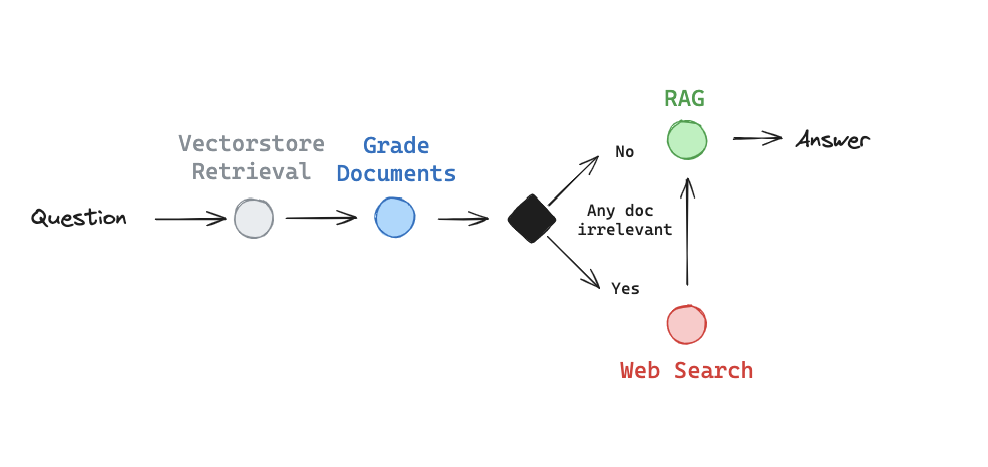

## Setup

We'll use [Ollama](https://ollama.ai/) to access a local LLM:

* Download [Ollama app](https://ollama.ai/).
* Pull your model of choice, e.g.: `ollama pull llama3`

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use a vectorstore with [Nomic local embeddings](https://blog.nomic.ai/posts/nomic-embed-text-v1) or, optionally, OpenAI embeddings.


Let's install our required packages and set our API keys:

In [ ]:
%%capture --no-stderr
%pip install -U langchain_community tiktoken langchainhub scikit-learn langchain langgraph tavily-python  nomic[local] langchain-nomic langchain_openai

In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

### LLM

You can select from [Ollama LLMs](https://ollama.com/library).

In [1]:
local_llm = "llama3"
model_tested = "llama3-8b"
metadata = f"CRAG, {model_tested}"

## Create Index

Let's index 3 blog posts.

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings  # local
from langchain_openai import OpenAIEmbeddings  # api

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Embedding
"""
embedding=NomicEmbeddings(
    model="nomic-embed-text-v1.5",
    inference_mode="local",
)
"""
embedding = OpenAIEmbeddings()

# Add the document chunks to the "vector store"
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Define Tools

In [3]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_mistralai.chat_models import ChatMistralAI

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

{'score': '1'}


In [4]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

The document mentions "memory stream" which is a long-term memory module that records a comprehensive list of agents' experience in natural language. It also discusses short-term memory and long-term memory, with the latter providing the agent with the capability to retain and recall information over extended periods. Additionally, it mentions planning and reflection mechanisms that enable agents to behave conditioned on past experience.


In [5]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## Create the Graph 

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

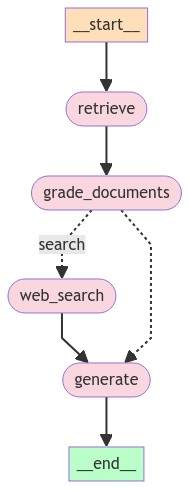

In [6]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
import uuid


def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_local_answer(example)
response

{'response': 'According to the documents, there are two types of agent memory:\n\n* Short-term memory (STM): This is a data structure that holds information temporarily and allows the agent to process it when needed.\n* Long-term memory (LTM): This provides the agent with the capability to retain and recall information over extended periods.\n\nThese types of memories allow the agent to learn, reason, and make decisions.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

Trace: 

https://smith.langchain.com/public/88e7579e-2571-4cf6-98d2-1f9ce3359967/r

## Evaluation

Now we've defined two different agent architectures that do roughly the same thing!

We can evaluate them. See our [conceptual guide](https://docs.smith.langchain.com/concepts/evaluation#agents) for context on agent evaluation.

### Response

First, we can assess how well [our agent performs on a set of question-answer pairs](https://docs.smith.langchain.com/tutorials/Developers/agents#response-evaluation).

We'll create a dataset and save it in LangSmith.

In [8]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    (
        "How does the ReAct agent use self-reflection? ",
        "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs.",
    ),
    (
        "What are the types of biases that can arise with few-shot prompting?",
        "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias.",
    ),
    (
        "What are five types of adversarial attacks?",
        "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming.",
    ),
    (
        "Who did the Chicago Bears draft first in the 2024 NFL draft”?",
        "The Chicago Bears drafted Caleb Williams first in the 2024 NFL draft.",
    ),
    ("Who won the 2024 NBA finals?", "The Boston Celtics on the 2024 NBA finals"),
]

# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

Now, we'll use an `LLM as a grader` to compare both agent responses to our ground truth reference answer.

[Here](https://smith.langchain.com/hub/rlm/rag-answer-vs-reference) is the default prompt that we can use.

We'll use `gpt-4o` as our LLM grader.


In [9]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Define an LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_v_reference_score", "score": score}

### Trajectory

Second, [we can assess the list of tool calls](https://docs.smith.langchain.com/tutorials/Developers/agents#trajectory) that each agent makes relative to expected trajectories.

This evaluates the specific reasoning traces taken by our agents!

In [10]:
from langsmith.schemas import Example, Run

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]


def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned
    """
    tool_calls = [tc['name'] for m in messages['messages'] for tc in getattr(m, 'tool_calls', [])]
    return tool_calls


def check_trajectory_react(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    messages = root_run.outputs["messages"]
    tool_calls = find_tool_calls_react(messages)
    print(f"Tool calls ReAct agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}


def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

In [11]:
from langsmith.evaluation import evaluate

experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_local_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    max_concurrency=1,  # Use when running locally
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'custom-agent-llama3-8b-answer-and-tool-use-d6006159' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/a8b9273b-ca33-4e2f-9f69-9bbc37f6f51b/compare?selectedSessions=83c60822-ef22-43e8-ac85-4488af279c6f




0it [00:00, ?it/s]

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom a

We can see the results benchmarked against `GPT-4o` and `Llama-3-70b` using `Custom` agent (as shown here) and ReAct.

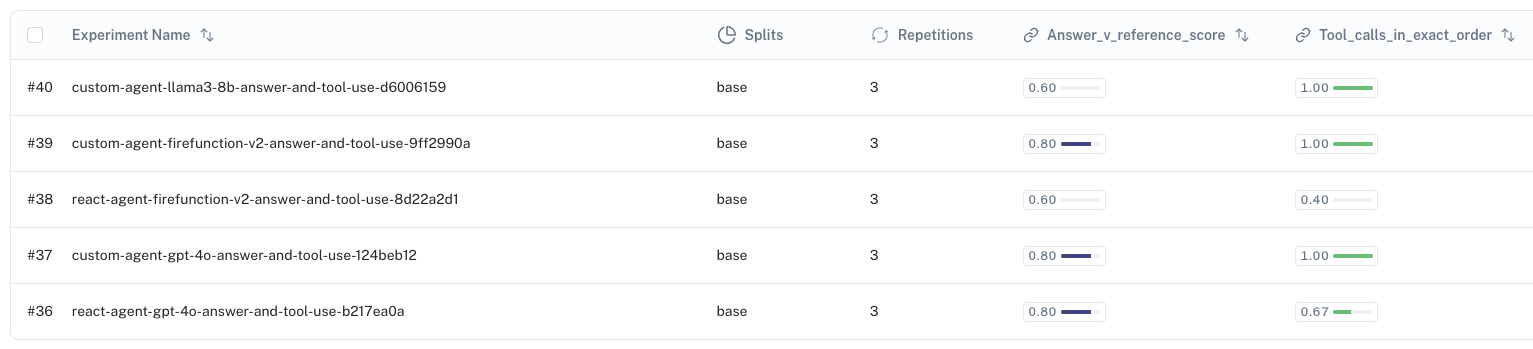

The `local custom agent` performs well in terms of tool calling reliability: it follows the expected reasoning traces.

However, the answer accuracy performance lags the larger models with `custom agent` implementations.